**Phase "2.5" running final data against Phase 2 Models---9/6/2019**

___
Description of Phase 2 contents

**This script takes the best models and features from Phase 1 of the model selection process and undertakes a deeper dive in reviewing/selecting the optimal models.  It also adapts wrangling steps to a Pipeline and embeds that pipeline in the fit_and_evaluate function from Dr. Bengfort's WheatClassification lab.**

To-Do:
- Use balanced sample of 50K observations DONE
- Align features across scripts DONE for outcome variable - PENDING for features (uniformly scale, reformat, normalize as we consolidate code---regularization; BZ)
- Substitute dummies for label encoding, create a pipeline DONE except for two where I need guarateed "1" values
- Add CV with 12 folds and randomized splits DONE
- Review validation curve (PENDING - BZ)
- Precision and Recall - DONE
- Robustness checks for county_type versus MSA binary, state features PENDING - Will do on 8/28 BZ
- Grid search PENDING - Will do on 8/28
- Analyses on all years PENDING - Dependency on wrangling
- Test for collinearity (heat map)
- Updated visuals and single year model validation PENDING
-----
Week of 9/3:
- Holdout sets
- Review learning curve
- Balanced and unbalanced datasets; random-stratifed+random-stratified-balanced
- Sync with Django

In [46]:
%matplotlib inline 

import os
import psycopg2
import json 
import time
import pickle
import pandas as pd 
import seaborn as sns

from sklearn.datasets.base import Bunch
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import NotFittedError
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold
from sklearn import preprocessing
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [27]:
con = psycopg2.connect(host="",database="", user="", password="", port="5432")
cur = con.cursor()
cur.execute("SET search_path TO interim_datasets_v2")
query_statement = '''SELECT * FROM hmda_2016_2017_union_srandom_bal_50k;''' 
DATA = pd.read_sql_query(query_statement, con)
DATA.describe(include='all')

,act_outc,action_year,rate_spread,denials,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,num_1to4_fam_units,ln_amt_000s,...,msamd_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
count,50000.000000,50000.000000,25000.000000,50000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,NaN,NaN,NaN,233,NaN,NaN,NaN,NaN,NaN,NaN,...,409,3,2,5,8,5,4,7,4,6
top,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,...,,Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD
freq,NaN,NaN,NaN,25000,NaN,NaN,NaN,NaN,NaN,NaN,...,9091,44387,49828,29340,29340,29340,30436,36446,37088,21664
mean,0.500000,2016.500000,3.031780,NaN,106.845303,5371.13436,33.037717,1387.193620,1937.848660,171.839320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.500005,0.500005,1.900942,NaN,38.216210,2692.61364,27.274940,731.343111,927.383152,509.700846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2016.000000,1.500000,NaN,0.000000,160.00000,0.000000,0.000000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2016.000000,1.730000,NaN,82.580000,3690.00000,10.530000,907.000000,1335.000000,55.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.500000,2016.500000,2.190000,NaN,101.700000,4948.00000,24.765000,1285.000000,1806.000000,112.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2017.000000,3.820000,NaN,124.500000,6477.00000,49.590000,1739.000000,2377.000000,210.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'interim_datasets_v2'""")
for table in cur.fetchall():
    print(table)

('hmda16_srandom_bal_25k',)
('hmda_2016_2017_union_srandom_bal_50k',)
('interim_hmda_2010_2017_simplerand_balanced200k',)
('hmda17_srandom_bal_25k',)


In [29]:
cur.close()
con.close()

In [30]:
DATA['locality_type'] = None
cloc = DATA.columns.get_loc('locality_type')
i = 0
for x in DATA['msamd_nm'].isna():
    if x == True:
        DATA.iat[i, cloc]= 0
        
    else: 
        DATA.iat[i, cloc]= 1
        
    i+=1
        
DATA['locality_type'] = DATA['locality_type'].astype('int64')


In [ ]:
#Stock code for eventually converting denials field
#DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)

In [39]:
#Drop rate_spread and denials, along with msamd_nm
#ISSUE: rate_spread is missing 50% of the time.  Dropping for now.
#ISSUE: also dropping state_abbr 
remove = ['rate_spread',
        'denials',
        'state_abbr',
        'msamd_nm']

categorical = ['property_type_nm', 
            'own_occ_nm', 
            'lien_status_nm', 
            'hoep_status_nm', 
            'co_appl_sex', 
            'co_appl_race', 
            'co_appl_ethn', 
            'applic_sex', 
            'applic_race', 
            'applic_ethn', 
            'agency_abbr'
            ]

non_bool_numeric = ['action_year', 
                    'tract_to_msamd_inc', 
                    'pop', 
                    'minority_pop_perc', 
                    'num_owoc_units', 
                    'num_1to4_fam_units', 
                    'ln_amt_000s', 
                    'hud_med_fm_inc', 
                    'applic_inc_000s'
                    ]

In [32]:
DATA = DATA.drop(remove, axis=1)
X = DATA[[col for col in DATA.columns if col != 'act_outc']]
y = DATA['act_outc']

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
action_year           50000 non-null int64
tract_to_msamd_inc    50000 non-null float64
pop                   50000 non-null int64
minority_pop_perc     50000 non-null float64
num_owoc_units        50000 non-null int64
num_1to4_fam_units    50000 non-null int64
ln_amt_000s           50000 non-null int64
hud_med_fm_inc        50000 non-null int64
applic_inc_000s       50000 non-null int64
property_type_nm      50000 non-null object
own_occ_nm            50000 non-null object
lien_status_nm        50000 non-null object
hoep_status_nm        50000 non-null object
co_appl_sex           50000 non-null object
co_appl_race          50000 non-null object
co_appl_ethn          50000 non-null object
applic_sex            50000 non-null object
applic_race           50000 non-null object
applic_ethn           50000 non-null object
agency_abbr           50000 non-null object
locality_type   

In [34]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "testdataphase2_5.csv"))
DATA.to_csv(filepath, index=False)

In [35]:
print(DATA.shape)
print(X.shape)
DATA.describe(include='all')

(50000, 22)
(50000, 21)


,act_outc,action_year,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,num_1to4_fam_units,ln_amt_000s,hud_med_fm_inc,applic_inc_000s,...,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr,locality_type
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,5,8,5,4,7,4,6,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44387,49828,29340,29340,29340,30436,36446,37088,21664,NaN
mean,0.500000,2016.500000,106.845303,5371.13436,33.037717,1387.193620,1937.848660,171.839320,66383.500000,93.703400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,0.500005,0.500005,38.216210,2692.61364,27.274940,731.343111,927.383152,509.700846,14258.674397,149.180118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,0.000000,2016.000000,0.000000,160.00000,0.000000,0.000000,0.000000,1.000000,14400.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,0.000000,2016.000000,82.580000,3690.00000,10.530000,907.000000,1335.000000,55.000000,57300.000000,42.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,0.500000,2016.500000,101.700000,4948.00000,24.765000,1285.000000,1806.000000,112.000000,64300.000000,66.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.000000,2017.000000,124.500000,6477.00000,49.590000,1739.000000,2377.000000,210.000000,73400.000000,106.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [36]:
meta = {
    'target_names': [str(yi) for yi in y.unique()],
    'feature_names': list(X.columns),
    'categorical_features': {
        column: list(X[column].unique())
        for column in X.columns
        if X[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
     json.dump(meta, f, indent=2)

In [37]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the HMDA dataset
    filenames     = {
        'meta': os.path.join(root, 'data','meta.json'),
        'rdme': os.path.join("..",'readme.md'),
        'data': os.path.abspath(os.path.join( "..", "fixtures", "testdataphase2_5.csv")),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = pd.read_csv(filenames['data'], low_memory=False)

    # Extract the target from the data
    data = dataset[[col for col in DATA.columns if col != 'act_outc']]
    target = dataset['act_outc']

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        categorical_features = meta['categorical_features'], 
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)

(50000, 21)


From Dr. Bengfort's Census Notebook:

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [38]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

**Create Pipeline**

In [40]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_bool_numeric),
        ('cat', categorical_transformer, categorical)])

In [41]:
preprocessor.fit_transform(dataset.data).shape

(50000, 58)

**Test Pipeline**

In [42]:
X = dataset.data
y = dataset.target

In [43]:
#Create a list object to eventually make the below cells iteratable
models = [
    GaussianNB(), 
    BernoulliNB(),
    tree.DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs', max_iter=6000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    LinearSVC(max_iter=6000),
    SGDClassifier()
]

In [47]:
def fit_and_evaluate(X, y, model, label, **kwargs):

    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}

    scores = {'precision':[], 'precision_1':[], 'precision_0':[], 'recall':[], 'recall_1':[], 'recall_0':[], 'accuracy':[], 'f1':[],  'f1_1':[],  'f1_0':[]}
    
    skf = StratifiedKFold(n_splits = 12, shuffle=True, random_state=1)
    
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
        
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        cr = classification_report(y_test, predicted, output_dict=True)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['precision_1'].append(cr['1']['precision'])
        scores['precision_0'].append(cr['0']['precision'])
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['recall_1'].append(cr['1']['recall'])
        scores['recall_0'].append(cr['0']['recall'])
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        scores['f1_1'].append(cr['1']['f1-score'])
        scores['f1_0'].append(cr['0']['f1-score'])
        
    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [48]:
fit_and_evaluate(X, y, LogisticRegression, "HMDA Logistic Regression", max_iter=6000)

Build and Validation of HMDA Logistic Regression took 15.892 seconds
Validation scores are as follows:

precision      0.692368
precision_1    0.704599
precision_0    0.680138
recall         0.691580
recall_1       0.659840
recall_0       0.723320
accuracy       0.691580
f1             0.691265
f1_1           0.681474
f1_0           0.701056
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-logistic-regression.pickle


In [50]:
fit_and_evaluate(X, y, RandomForestClassifier, "HMDA Random Forest Classifier", n_estimators=100)

Build and Validation of HMDA Random Forest Classifier took 86.011 seconds
Validation scores are as follows:

precision      0.724882
precision_1    0.721423
precision_0    0.728342
recall         0.724800
recall_1       0.732400
recall_0       0.717200
accuracy       0.724800
f1             0.724776
f1_1           0.726848
f1_0           0.722704
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-random-forest-classifier.pickle


In [51]:
fit_and_evaluate(X, y, LinearDiscriminantAnalysis, "HMDA Linear Discriminant Analysis")

Build and Validation of HMDA Linear Discriminant Analysis took 6.592 seconds
Validation scores are as follows:

precision      0.691217
precision_1    0.704360
precision_0    0.678075
recall         0.690300
recall_1       0.656000
recall_0       0.724600
accuracy       0.690300
f1             0.689930
f1_1           0.679306
f1_0           0.700555
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linear-discriminant-analysis.pickle


In [52]:
fit_and_evaluate(X, y, LinearSVC, "HMDA LinearSVC")

Build and Validation of HMDA LinearSVC took 114.895 seconds
Validation scores are as follows:

precision      0.693308
precision_1    0.706040
precision_0    0.680575
recall         0.692460
recall_1       0.659560
recall_0       0.725360
accuracy       0.692460
f1             0.692124
f1_1           0.682000
f1_0           0.702247
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linearsvc.pickle


In [53]:
fit_and_evaluate(X, y, BernoulliNB, "HMDA BernoulliNB")

Build and Validation of HMDA BernoulliNB took 2.952 seconds
Validation scores are as follows:

precision      0.660160
precision_1    0.660852
precision_0    0.659469
recall         0.660140
recall_1       0.657999
recall_0       0.662280
accuracy       0.660140
f1             0.660129
f1_1           0.659404
f1_0           0.660853
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-bernoullinb.pickle


In [54]:
fit_and_evaluate(X, y, GaussianNB, "HMDA GaussianNB")

Build and Validation of HMDA GaussianNB took 3.312 seconds
Validation scores are as follows:

precision      0.663896
precision_1    0.788251
precision_0    0.539542
recall         0.569159
recall_1       0.187077
recall_0       0.951240
accuracy       0.569159
f1             0.493953
f1_1           0.299511
f1_0           0.688395
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-gaussiannb.pickle


In [55]:
fit_and_evaluate(X, y, tree.DecisionTreeClassifier, "HMDA DecisionTreeClassifier")

Build and Validation of HMDA DecisionTreeClassifier took 11.403 seconds
Validation scores are as follows:

precision      0.651350
precision_1    0.650596
precision_0    0.652105
recall         0.651320
recall_1       0.653719
recall_0       0.648920
accuracy       0.651320
f1             0.651303
f1_1           0.652126
f1_0           0.650480
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-decisiontreeclassifier.pickle


In [56]:
fit_and_evaluate(X, y, BaggingClassifier, "HMDA BaggingClassifier")     

Build and Validation of HMDA BaggingClassifier took 56.612 seconds
Validation scores are as follows:

precision      0.701775
precision_1    0.715564
precision_0    0.687986
recall         0.700820
recall_1       0.666680
recall_0       0.734960
accuracy       0.700820
f1             0.700466
f1_1           0.690245
f1_0           0.710688
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-baggingclassifier.pickle


In [57]:
fit_and_evaluate(X, y, ExtraTreesClassifier, "HMDA ExtraTreesClassifier", n_estimators=100)

Build and Validation of HMDA ExtraTreesClassifier took 85.870 seconds
Validation scores are as follows:

precision      0.703380
precision_1    0.700720
precision_0    0.706040
recall         0.703319
recall_1       0.709879
recall_0       0.696759
accuracy       0.703319
f1             0.703297
f1_1           0.705248
f1_0           0.701346
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-extratreesclassifier.pickle


In [58]:
fit_and_evaluate(X, y, SGDClassifier, "HMDA SGDClassifier")

Build and Validation of HMDA SGDClassifier took 3.421 seconds
Validation scores are as follows:

precision      0.669884
precision_1    0.675190
precision_0    0.664578
recall         0.648640
recall_1       0.624430
recall_0       0.672851
accuracy       0.648640
f1             0.636766
f1_1           0.630470
f1_0           0.643062
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-sgdclassifier.pickle


**Coding out a Learning Curve**
250,000, 500,000, 750,000, 1,000,000

https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

In [59]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

In [60]:
# Encode the categorical data
X = preprocessor.fit_transform(dataset.data)
#y = dataset.target

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

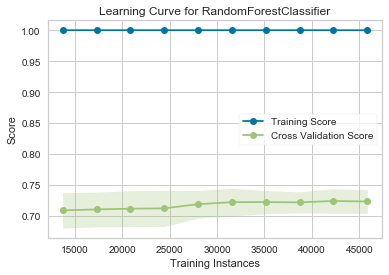

In [61]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=100)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

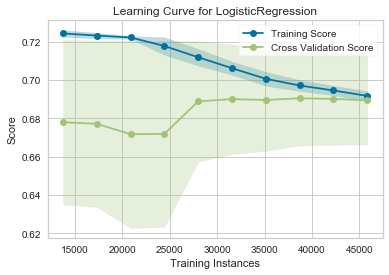

In [62]:
# Instantiate the classification model and visualizer
model = LogisticRegression(max_iter=6000)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

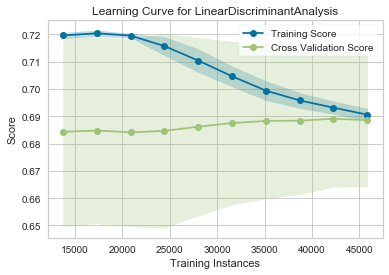

In [63]:
# Instantiate the classification model and visualizer
model = LinearDiscriminantAnalysis()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

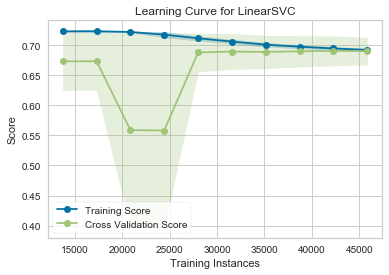

In [64]:
# Instantiate the classification model and visualizer
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

The last step is to save our model to disk for reuse later, with the `pickle` module:

In [ ]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=dataset):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)